In [ ]:
"""
This file first selects the seeds and the end-point patterns according to the specified number of seeds
then, uses Stable Diffusion Encoder to encode the end-point patterns, and then decode them back using the Decoder. 
Images are displayed to depict the out-of-box reconstruction accuracy. 

"""

In [ ]:
# import libraries

import os
import re
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL
from PIL import Image
import torch


/hpc/dctrl/ks723/miniconda3/envs/test_pytorch_ipy_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-03-18 17:13:33,206] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
"""
This file loads both the simulation and the seed directory and selects a sets of seeds according to the desired seed counts 

"""

# Paths to the JSON file and directories
output_file = '/hpc/group/youlab/ks723/miniconda3/Lingchong/Sim_050924_seed_counts_testset_60000_70000.json'
input_dir = '/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_050924/Sim_input/intermediate/Tp3'  # Directory containing 'Output_...png' images
output_dir ="/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_050924/Sim_output"        # Directory containing 'Input_...png' images

# Load seed counts from JSON
with open(output_file, 'r') as f:
    seed_counts = json.load(f)

# Desired seed counts
desired_seed_counts = [1, 2, 4, 8, 16]

# Initializing lists
input_images=[]
output_images=[]

# Dictionary to hold selected filenames
selected_images = {}

# Loop over desired seed counts and select one image for each
for seed_count in desired_seed_counts:
    # Find an image with this seed count
    for filename, count in seed_counts.items():
        if count == seed_count and filename.startswith('Input'):
            # Check if we have already selected an image for this seed count
            if seed_count not in selected_images:
                # Select this image
                selected_images[seed_count] = filename
                break  # Stop searching for this seed count

# Now, for each selected image, get the corresponding output image filename and load the images
for seed_count, input_filename in selected_images.items():
    # Get the output filename by replacing 'Input' with 'Output'
    output_filename = re.sub(r'^Input', 'Output', input_filename)

    # Construct the full paths
    input_path = os.path.join(input_dir, output_filename)
    output_path = os.path.join(output_dir, input_filename)

    # Load the images using OpenCV or any other library
    input_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    output_image = cv2.imread(output_path, cv2.IMREAD_GRAYSCALE)

    # Check if images are loaded correctly
    if input_image is None:
        print(f"Failed to load input image: {input_path}")
        continue
    if output_image is None:
        print(f"Failed to load output image: {output_path}")
        continue

    # Append to lists
    input_images.append(input_image)
    output_images.append(output_image)



In [6]:
"""
Loading the desired dataset 

"""


# Set resizing factor
rfactor = 256

# Prepare the data
data = []

def create_data():
    for img in input_images:
        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize it for consistency
        img_rgb_resized = cv2.resize(img_rgb, (rfactor, rfactor))
        data.append(img_rgb_resized)
    # Assuming all images have the same shape
    image_shape = data[0].shape
    return image_shape


shape_row,shape_col,shape_channel=create_data()
# print(shape)

X1=data  
X1 = np.array(X1)
X1 = np.transpose(X1, (0, 3, 1, 2))  # Convert from (N, H, W, C) to (N, C, H, W)
X1 = X1 / 255.0  # Normalize the images


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
X = torch.Tensor(X1)


In [7]:

"""
Load the pre trained SD VAE, encode images from dataset using Encoder and then decode them back using Decoder
"""

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

def encode_img(input_img):
    # input_img = input_img.repeat(3, 1, 1)
    
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    if len(input_img.shape)<4:
        input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(input_img*2 - 1) # Note scaling  # to make outputs from -1 to 1 
    return 0.18215 * latent.latent_dist.sample()

def decode_img(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)    # to make outputs from 0 to 1 
    image = image.detach()
    return image


# Encode the images
encoded_latents = []

# encode latent 

for img in range(0, X.shape[0]) :
    latent = encode_img(X[img,:,:,:])
    encoded_latents.append(latent)


input_images_list=encoded_latents

# Convert the list of tensors to a numpy array
image_np = np.concatenate(input_images_list, axis=0)

# Now final_image_array contains the processed images with the desired properties
print("Shape of image array:",image_np.shape)

yprime=image_np
yprime=torch.Tensor(yprime)

def scale_latents(latent):
    # Normalize latent for visualization
    latent = latent - latent.min()
    latent = latent / latent.max()
    return latent


yprime_scaled=scale_latents(yprime)
reconstructed_images=decode_img(yprime)


/hpc/dctrl/ks723/miniconda3/envs/test_pytorch_ipy_v2/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Shape of image array: (5, 4, 32, 32)


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


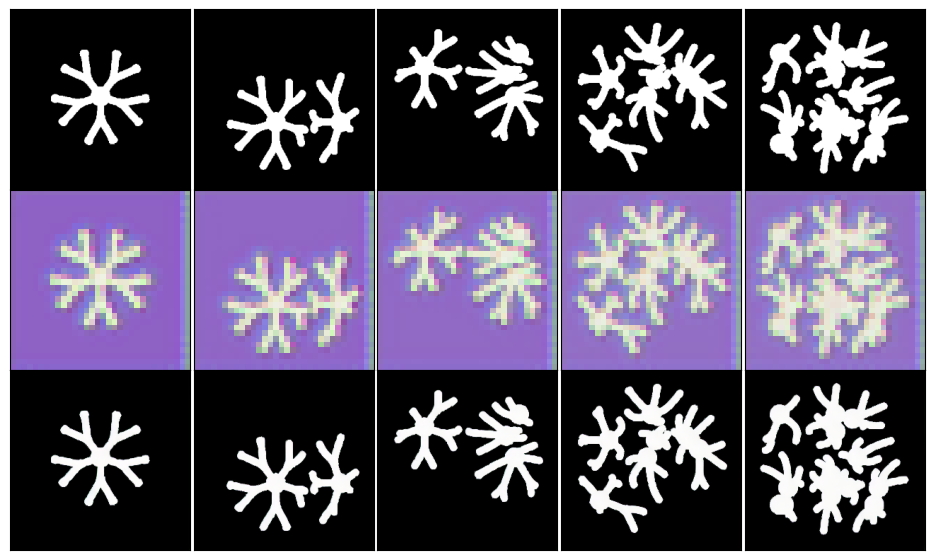

In [8]:

def tensor_to_pil_v2(tensor):  
    tensor = tensor.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    tensor = tensor.cpu().numpy()
    tensor = (tensor * 255).astype('uint8')
    return Image.fromarray(tensor)



# for generation see first row seed, second row compressed patterns, third row reconstructed patterns


def display_predicted_images(input_seed,final_patterns,pred_images, num_samples):
   
    fig, ax = plt.subplots( 3,num_samples, figsize=(10,6) ) 
    fig.tight_layout()

    plt.subplots_adjust(wspace=0.001, hspace=0.001)

    for i in range(num_samples):

        # image_i=input_seed[i,:,:,:].reshape(shape_row,shape_col,shape_channel)
     
        image_i=tensor_to_pil_v2(input_seed[i,:,:,:])
        image_o=tensor_to_pil_v2(final_patterns[i,:,:,:])
        image_p= tensor_to_pil_v2(pred_images[i,:,:,:].to("cpu"))
      
       

        ax[0,i].imshow(image_i,cmap='gray')
        ax[0,i].get_xaxis().set_visible(False)
        ax[0,i].get_yaxis().set_visible(False)
    

        ax[1,i].imshow(image_o,cmap='gray')
        ax[1,i].get_xaxis().set_visible(False)
        ax[1,i].get_yaxis().set_visible(False)
        

        ax[2,i].imshow(image_p,cmap="gray")
        ax[2,i].get_xaxis().set_visible(False)
        ax[2,i].get_yaxis().set_visible(False)
      
        print(np.array(image_p).shape)
    
        

    plt.show()
    plt.tight_layout

# Display samples from dataset
display_predicted_images(X,yprime_scaled, reconstructed_images ,5) # 